In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [124]:
%matplotlib inline
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20

sns.set_style('white')

np.random.seed(42)

# dataset -- MNIST

In [3]:
from sklearn.datasets import fetch_mldata

In [4]:
mnist = fetch_mldata('MNIST original') 

In [5]:
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [6]:
mnist.keys()

dict_keys(['DESCR', 'COL_NAMES', 'data', 'target'])

In [7]:
X = mnist['data']
y = mnist['target']

In [8]:
print('feature space is:', X.shape)
print('response space is :', y.shape)
print('pixel for each image is', int(np.sqrt(X.shape[1])))

feature space is: (70000, 784)
response space is : (70000,)
pixel for each image is 28


# Visualization

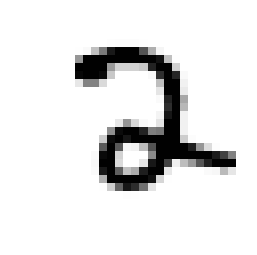

In [9]:
digit_img = X[np.random.randint(0, X.shape[0]),:]
digit_img = digit_img.reshape(28, 28)
plt.imshow(digit_img, interpolation="nearest");
plt.axis("off");

In [10]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

In [11]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

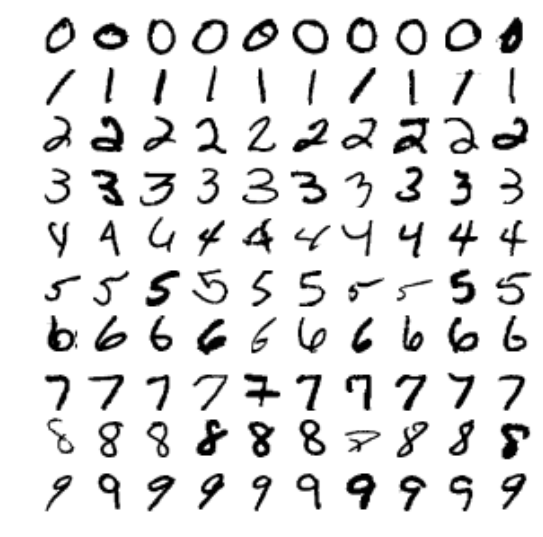

In [12]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)

### split the train and test set

In [13]:
xtrain, xtest, ytrain, ytest = X[:60000], X[60000:], y[:60000], y[60000:]

In [14]:
# shuffle the indices randomly such that labels are randomly located
shuffle_idx = np.random.permutation(60000)

In [15]:
xtrain, ytrain = xtrain[shuffle_idx], ytrain[shuffle_idx]

# build classifiers

In [16]:
# define the target label as 5
target_label = 5

In [17]:
ytrain_5 = (ytrain == 5)
ytest_5 = (ytest == 5)

In [18]:
from sklearn.linear_model import SGDClassifier

In [19]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(xtrain, ytrain_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

## cross-validation using sklearn function

In [20]:
from sklearn.model_selection import cross_val_score

In [21]:
cross_val_score(sgd_clf, xtrain, ytrain_5, cv = 5, scoring='accuracy')

array([ 0.94658778,  0.9595    ,  0.962     ,  0.96483333,  0.96708059])

## cross-validation using sklearn straitified shuffle

In [22]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [23]:
skfolds = StratifiedKFold(n_splits=5, random_state=42)

In [24]:
# we need to call the split() function after using stratifiedKFold object
for train_idx, test_idx in skfolds.split(xtrain, ytrain_5):
    xtrain_folds = xtrain[train_idx]
    ytrain_5_folds = ytrain_5[train_idx]
    
    # --- because we are doing cross-validation, so we only split the training set
    xtest_folds = xtrain[test_idx]
    ytest_5_folds = ytrain_5[test_idx]
    
    clone_sgdclf = clone(sgd_clf)
    
    clone_sgdclf.fit(xtrain_folds, ytrain_5_folds)
    prediction = clone_sgdclf.predict(xtest_folds)
    
    corrections = sum(prediction == ytest_5_folds) / len(ytest_5_folds)
    
    print(corrections)

0.946587784351
0.9595
0.962
0.964833333333
0.967080590049


# Precision and Recall

In [25]:
from sklearn.model_selection import cross_val_predict

In [26]:
ytrain_pred = cross_val_predict(sgd_clf, xtrain, ytrain_5, cv=5)

In [27]:
sum(ytrain_pred==ytrain_5)/len(ytrain_5)

0.95999999999999996

In [28]:
from sklearn.metrics import confusion_matrix

confusion_matrix with the form:

                           prediction
                  negative            positive
     negative        TN                  FP
 
     positive        FN                  TP

In [29]:
conf_mat = confusion_matrix(ytrain_pred, ytrain_5)
print(conf_mat)

[[53954  1775]
 [  625  3646]]


In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [31]:
prec_score = precision_score(ytrain_5, ytrain_pred)
print('precision score:', prec_score)

precision score: 0.853664247249


precision = TP / (TP + FN)

In [32]:
conf_mat[1, 1] / (conf_mat[1, 1] + conf_mat[1, 0])

0.8536642472488879

In [33]:
recall_score = recall_score(ytrain_5, ytrain_pred)
print('recall score:', recall_score)

recall score: 0.672569636598


recall = TP / (TP + FP)

In [34]:
conf_mat[1, 1] / (conf_mat[1, 1] + conf_mat[0, 1])

0.67256963659841362

In [35]:
f1_score = f1_score(ytrain_5, ytrain_pred)
print('f1 score:', f1_score)

f1 score: 0.752373091209


f1  =  (2 $*$ recall $*$ precision) / (recall + precision)

## precision_recall_curve

In order to use precision_recall_curve, predictions being value returned from decision_function() can be visualized more clearly that how precision/recall vary according to threshold in terms of score.

In [36]:
from sklearn.metrics import precision_recall_curve

In [37]:
ytrain_pred_score = sgd_clf.decision_function(xtrain)

In [38]:
ytrain_pred_score.shape

(60000,)

In [39]:
precisions_predfnc, recalls_predfnc, thresholds_predfnc = precision_recall_curve(ytrain_5, ytrain_pred)

In [40]:
ytrain_pred.shape

(60000,)

In [41]:
precisions_predfnc

array([ 0.09035   ,  0.85366425,  1.        ])

In [42]:
precisions_decifnc, recalls_decifnc, thresholds_decifnc = precision_recall_curve(ytrain_5, ytrain_pred_score)

plot precision against recall at different levels of thresholds

In [43]:
def plot_precision_recall_thresholds(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision', linewidth = 2)
    plt.plot(thresholds, recalls[:-1], 'g--', label='Recall', linewidth = 2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="best", fontsize=16)
    plt.ylim([0, 1])

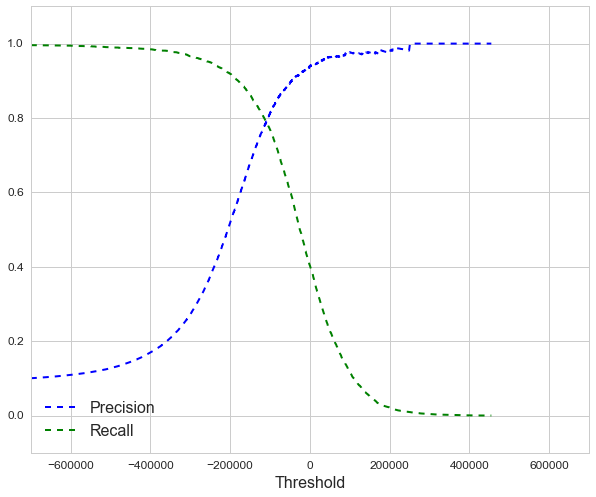

In [44]:
plt.figure(figsize=(10,8))
plot_precision_recall_thresholds(precisions_decifnc, recalls_decifnc, thresholds_decifnc)
plt.xlim([-700000, 700000])
plt.ylim([-0.1, 1.1]);

[0, 1, 0, 1]

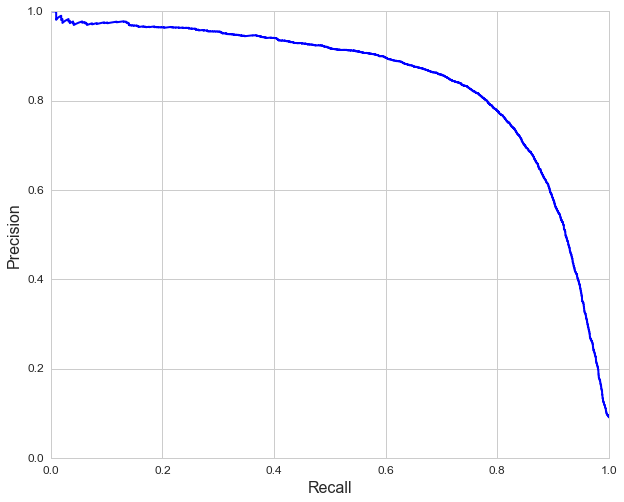

In [47]:
plt.figure(figsize=(10,8))
plt.plot(recalls_decifnc, precisions_decifnc, "b-", linewidth=2)
plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.axis([0, 1, 0, 1])

# ROC-AUC 

In [53]:
from sklearn.metrics import roc_curve, roc_auc_score, auc

In [54]:
fpr, tpr, thesholds = roc_curve(ytrain_5, ytrain_pred_score)

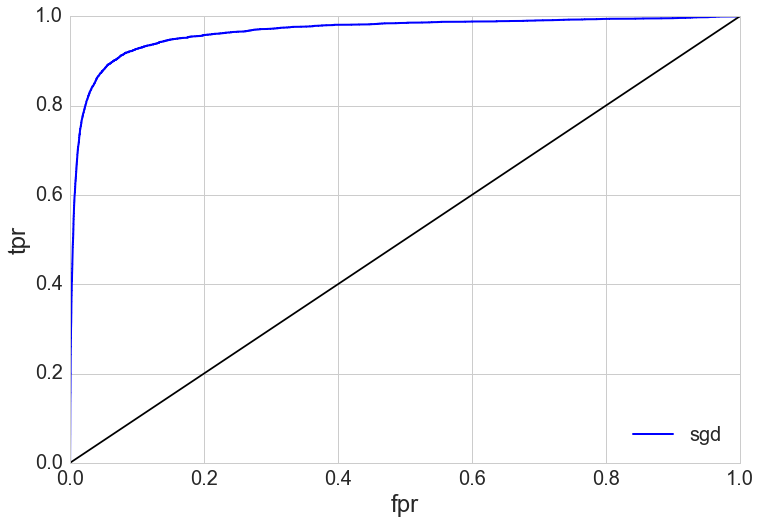

In [67]:
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, 'b', linewidth = 2, label='sgd')
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc='best', fontsize=20)
plt.xlabel('fpr')
plt.ylabel('tpr');

In [69]:
auc_sgd = roc_auc_score(ytrain_5, ytrain_pred_score)
print('AUC of sgd_clf is:', auc_sgd)

AUC of sgd_clf is: 0.966376407772


We now try the random forest

In [70]:
from sklearn.ensemble import RandomForestClassifier

In [72]:
RF = RandomForestClassifier(random_state=42)
RF.fit(xtrain, ytrain_5)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [74]:
ytrain_5_predprob_RF = RF.predict_proba(xtrain)
ytrain_5_pred_RF = ytrain_5_predprob_RF[:, 1]

Or use train RF with cross validation and make prediction

In [77]:
ytrain_5_predprob_RF = cross_val_predict(RF, xtrain, ytrain_5, cv=5, method="predict_proba")
ytrain_5_pred_RF = ytrain_5_predprob_RF[:, 1]

In [78]:
fpr_rf, tpr_rf, thesholds_rf = roc_curve(ytrain_5, ytrain_5_pred_RF)

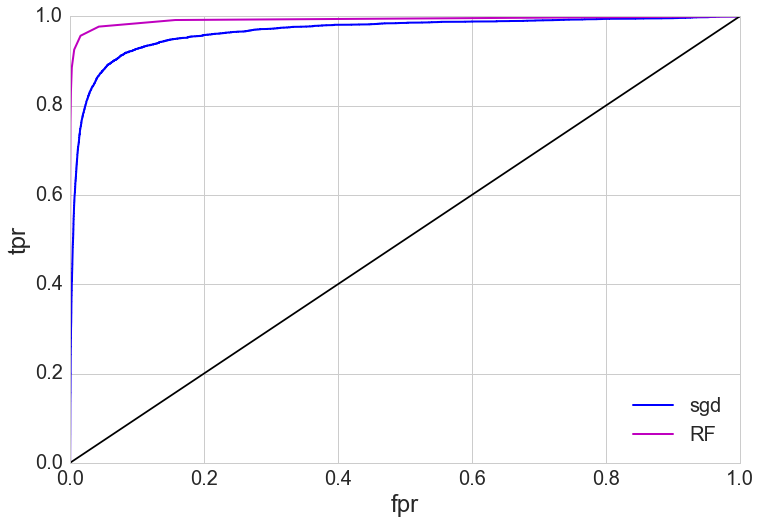

In [79]:
plt.figure(figsize=(12,8))
plt.plot(fpr, tpr, 'b', linewidth = 2, label='sgd')
plt.plot(fpr_rf, tpr_rf, 'm', linewidth = 2, label='RF')
plt.plot([0, 1], [0, 1], 'k')
plt.legend(loc='best', fontsize=20)
plt.xlabel('fpr')
plt.ylabel('tpr');

In [80]:
auc_RF = roc_auc_score(ytrain_5, ytrain_5_pred_RF)
print('AUC of RF is:', auc_RF)

AUC of RF is: 0.992461421567


Make prediction of digit using RF, without predict_prob

In [82]:
ytrain_5_pred_RF = cross_val_predict(RF, xtrain, ytrain_5, cv=5)

In [84]:
precision_score(ytrain_5, ytrain_5_pred_RF)

0.98492462311557794

In [86]:
from sklearn.metrics import recall_score
recall_score(ytrain_5, ytrain_5_pred_RF)

0.83158088913484596

# Multiclass classification

retrain the sgd classification using all labels

In [87]:
sgd_clf = SGDClassifier()
sgd_clf.fit(xtrain, ytrain)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [105]:
idx = np.random.randint(0, len(ytrain))
ytrain[idx]

2.0

In [106]:
sgd_clf.predict([xtrain[idx, :]])

array([ 2.])

In [109]:
sgd_clf.decision_function([xtrain[idx, :]])

array([[-578552.07844941, -309308.3623582 ,  210462.82232864,
        -217431.89908185, -169009.91216463, -498964.47720898,
        -279095.9040399 , -263558.44838157, -385164.62856415,
        -542102.95065766]])

In [110]:
np.argmax(sgd_clf.decision_function([xtrain[idx, :]]))

2

classes exist in the response variables that we use to model sgd_clf

In [111]:
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

#### standardize feature space

In [112]:
from sklearn.preprocessing import StandardScaler

In [115]:
scaler = StandardScaler()
xtrain_standard = scaler.fit_transform(xtrain.astype(np.float64))

In [116]:
cross_val_score(RF, xtrain_standard, ytrain, cv=5, scoring='accuracy')

array([ 0.945606  ,  0.94442593,  0.947     ,  0.943986  ,  0.94506502])

In [118]:
RF_pred = cross_val_predict(RF, xtrain_standard, ytrain, cv=5)

In [120]:
conf_mat_RF = confusion_matrix(ytrain, RF_pred)
conf_mat_RF

array([[5807,    4,   24,    5,    5,   17,   31,    2,   24,    4],
       [   2, 6627,   38,   16,   16,   10,    3,   13,   12,    5],
       [  49,   25, 5656,   45,   41,   11,   23,   42,   51,   15],
       [  26,   19,  144, 5671,    9,  104,    5,   49,   72,   32],
       [  15,   14,   32,    6, 5570,    5,   33,   15,   21,  131],
       [  41,   15,   22,  175,   19, 4980,   55,   15,   64,   35],
       [  51,   15,   30,    4,   21,   59, 5711,    0,   25,    2],
       [  12,   35,   70,   24,   73,    4,    1, 5944,   17,   85],
       [  29,   50,   85,  143,   47,   86,   31,   14, 5298,   68],
       [  30,   16,   34,   81,  150,   38,    8,   84,   59, 5449]])

### If you prefer color and a colorbar

In [138]:
def plot_confusion_matrix(matrix):    
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix, cmap=plt.cm.gray)
    fig.colorbar(cax)

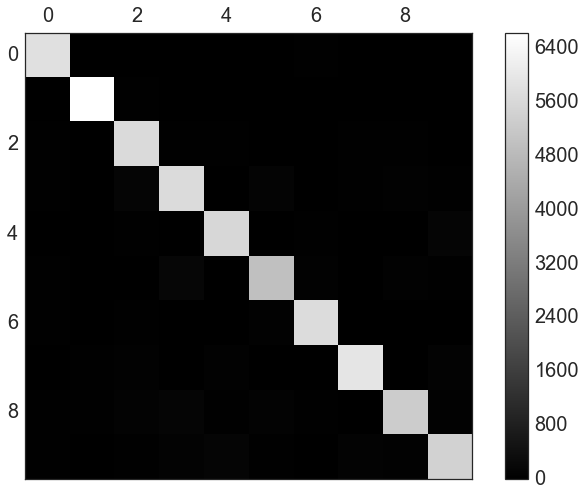

In [139]:
plot_confusion_matrix(conf_mat_RF)

### if we are interested in mis-classifications

In [171]:
# 1. get sample numbers in row-wise
row_conf_mat_sum = conf_mat_RF.sum(axis=1)

In [172]:
# 2. normalize the confusion matrix by dividing row_sum to each row
normalize_conf_mat_RF = conf_mat_RF / row_conf_mat_sum

In [173]:
# 3. fill diagonal elements with zeros
np.fill_diagonal(normalize_conf_mat_RF, 0)

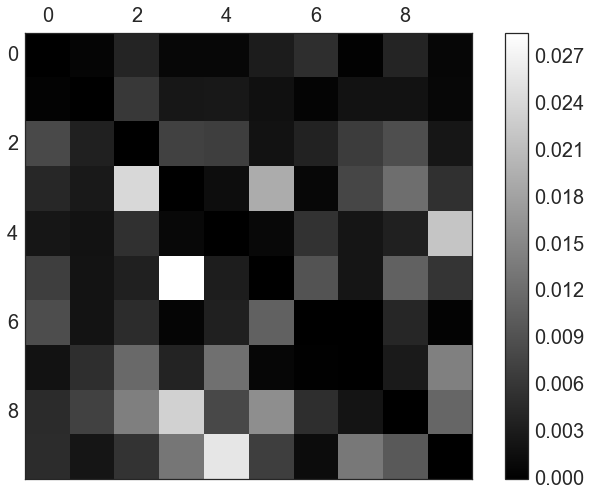

In [174]:
plot_confusion_matrix(normalize_conf_mat_RF)